In [1]:
#pip install -r ../requirements.txt

In [1]:
import pandas as pd
from transformers import AutoModelForSequenceClassification
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer,AutoTokenizer
import torch
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score,roc_curve, auc,f1_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
model = AutoModelForSequenceClassification.from_pretrained("voidism/diffcse-bert-base-uncased-trans", num_labels=1)
metric = evaluate.load("accuracy")
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch", num_train_epochs=7)

Some weights of the model checkpoint at ../models/diffcse-bert-base-uncased-trans were not used when initializing BertForSequenceClassification: ['aux_bert.encoder.layer.9.intermediate.dense.weight', 'aux_bert.encoder.layer.1.attention.output.dense.bias', 'generator.distilbert.transformer.layer.2.attention.v_lin.bias', 'aux_bert.encoder.layer.8.output.dense.bias', 'generator.distilbert.transformer.layer.4.attention.k_lin.weight', 'aux_bert.encoder.layer.10.attention.self.key.bias', 'aux_bert.encoder.layer.3.output.LayerNorm.weight', 'aux_bert.encoder.layer.9.attention.output.LayerNorm.bias', 'aux_bert.encoder.layer.9.attention.output.LayerNorm.weight', 'aux_bert.encoder.layer.7.intermediate.dense.bias', 'generator.distilbert.transformer.layer.4.ffn.lin1.bias', 'generator.distilbert.transformer.layer.5.ffn.lin2.bias', 'aux_bert.encoder.layer.10.attention.output.LayerNorm.bias', 'aux_bert.encoder.layer.8.attention.output.LayerNorm.bias', 'aux_bert.encoder.layer.3.output.dense.weight', 'a

In [3]:
dataset_test = pd.read_parquet(r'test_result_roft.parquet', engine='fastparquet')
dataset_test

,model,text,label
0,finetuned,HOW TO MAKE: Mango-Glazed Turkey Breast\nIngre...,0
1,davinci,"""Is she for real?That purse does *not* go with...",0
2,davinci,I think it was the waiting that really got to ...,0
3,gpt2-xl,New Yorkers have an amazing knack of creating ...,0
4,gpt2-xl,HOW TO MAKE: Easy Chicken Pot Pie\nIngredients...,0
...,...,...,...
6899,gpt2-xl,HOW TO MAKE: Gibna With Tamatum or Cheese With...,0
6900,finetuned,HOW TO MAKE: Awesome Easy Marinade for Meat or...,0
6901,ctrl-nocode,"""Fifth Annual Message"" by President Theodore R...",0
6902,ctrl-Politics,"""Statement at the International American Confe...",0


In [4]:
dataset_train = pd.read_parquet(r'train_result_roft.parquet', engine='fastparquet')
dataset_train

,model,text,label
0,gpt2-xl,WHEN it comes to visions of what New Haven par...,0
1,finetuned,HOW TO MAKE: Breakfast Burrito (Like Mc Donald...,0
2,finetuned,HOW TO MAKE: Hot Banana Creme Brulee\nIngredie...,0
3,davinci,HOW TO MAKE: Howard's Failsafe Chicken Pasta\n...,0
4,finetuned,HOW TO MAKE: Roast Leg of Lamb with Red Wine S...,0
...,...,...,...
20705,davinci,"NATO's plan to airlift 100,000 desperate refug...",0
20706,gpt2-xl,Amer Hamedi's family has had a bakery in Tripo...,0
20707,finetuned,HOW TO MAKE: Orzo-Portabella Casserole\nIngred...,0
20708,ctrl-Politics,"""Statement on the Resumption of Bombing in Nor...",0


In [5]:
dataset_test['label'] = dataset_test['label'].astype(float)
dataset_train['label'] = dataset_train['label'].astype(float)

In [6]:
dataset_train, dataset_eval, _, _ = train_test_split(dataset_train, dataset_train, test_size = 0.25,
                                                      shuffle = True, random_state = 42)

In [7]:
train_texts, train_labels = dataset_train['text'].tolist(),dataset_train['label'].tolist()
test_texts, test_labels = dataset_test['text'].tolist(),dataset_test['label'].tolist()
eval_texts, eval_labels = dataset_eval['text'].tolist(),dataset_eval['label'].tolist()

In [8]:
tokenizer = AutoTokenizer.from_pretrained("voidism/diffcse-bert-base-uncased-trans")
train_encodings = tokenizer(train_texts, return_tensors='pt',
                padding='max_length',
                max_length=512,
                truncation=True)
test_encodings = tokenizer(test_texts, return_tensors='pt',
                padding='max_length',
                max_length=512,
                truncation=True)
eval_encodings = tokenizer(eval_texts, return_tensors='pt',
                padding='max_length',
                max_length=512,
                truncation=True)

In [9]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [10]:
train_dataset = MyDataset(train_encodings, train_labels)
test_dataset = MyDataset(test_encodings, test_labels)
eval_dataset = MyDataset(eval_encodings, eval_labels)


In [11]:
optim_param = ['adafactor']#, 'adamw_torch']

In [12]:
trainer = []
result = []
final_lst = []
for opt in optim_param:
    training_args.optim = opt
    training_args.per_gpu_train_batch_size = 40
    trainer += [Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset
    )]
for i in range(len(trainer)):
    trainer[i].train()
    lst = []
    result_test_pred = trainer[i].predict(eval_dataset)
    for i in range(len(eval_dataset.labels)):
        lst+=[scipy.special.expit(result_test_pred[0][i][0])]
    final_lst+=[lst]
    result += [pd.DataFrame(zip(eval_dataset.labels,lst),columns = ['true','pred'])]

Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
/tmp/job-1413985/ipykernel_87172/3135598630.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/home/sslashinin/.conda/envs/nlp_env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a v

Epoch,Training Loss,Validation Loss
1,No log,0.044151
2,No log,0.027457
3,0.053100,0.028924
4,0.053100,0.017152
5,0.053100,0.017724
6,0.010200,0.023459
7,0.010200,0.016434


/tmp/job-1413985/ipykernel_87172/3135598630.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/home/sslashinin/.conda/envs/nlp_env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/tmp/job-1413985/ipykernel_87172/3135598630.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/home/sslashinin/.conda/envs/nlp_env/lib/python3.8/si

In [13]:
res = []
for i in range(len(result)):
    res+=[roc_auc_score(result[i]['true'], result[i]['pred'])]
max_value = max(res)
max_index = res.index(max_value)
max_index

0

In [14]:
def find_model(optim_list,max_index):
    i = 0
    best_model = []
    for num_1,opt in enumerate(optim_list):
        print(i,opt)
        if i == max_index:
            best_model= [opt]
            return best_model
        else:
            i+=1
        

In [15]:
best_model = find_model(optim_param,max_index)
best_model

0 adafactor


['adafactor']

In [16]:
result_test_pred = trainer[max_index].predict(test_dataset)

/tmp/job-1413985/ipykernel_87172/3135598630.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/home/sslashinin/.conda/envs/nlp_env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [17]:
lst = []
for i in range(len(test_dataset.labels)):
    lst+=[scipy.special.expit(result_test_pred[0][i][0])]
final_res = pd.DataFrame(zip(test_dataset.labels,lst),columns = ['true','pred'])
final_res

,true,pred
0,0.0,0.496784
1,0.0,0.501984
2,0.0,0.500988
3,0.0,0.499241
4,0.0,0.501097
...,...,...
6899,0.0,0.501674
6900,0.0,0.500799
6901,0.0,0.499027
6902,0.0,0.501824


In [18]:
def roc(test_result_old):   
    fpr, tpr, treshold = roc_curve(test_result_old['true'], test_result_old['pred'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
         label=f'ROC (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Совмещенные ROC-кривые')
    plt.legend(loc="lower right")
    plt.show()

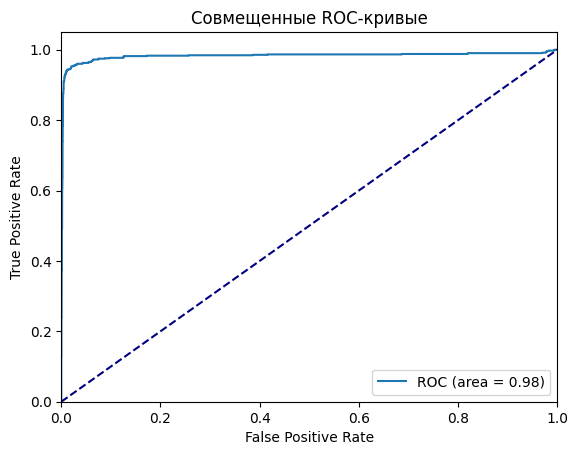

In [19]:
roc(final_res)

In [20]:
def confuns_matrix(train_rezalt_old):
    print(f'f1')
    print(f1_score(train_rezalt_old['true'].tolist(), [int(p>0.5) for p in train_rezalt_old['pred']], average='macro'))
    sns.heatmap(metrics.confusion_matrix(train_rezalt_old['true'],[int(p>0.5) for p in train_rezalt_old['pred']]),annot=True,cmap="Blues",square=True)
    plt.ylabel("label")
    plt.xlabel(f"")
    plt.title(f"Confusion matrix")
    plt.show()

f1
0.43072138044508546


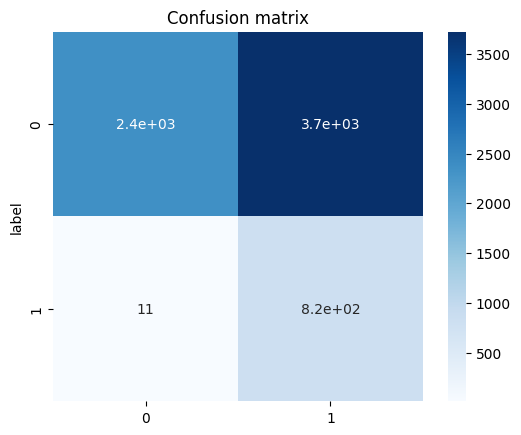

In [21]:
confuns_matrix(final_res)

In [22]:
final_res.to_csv("gen_results_bert.csv")